In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import SimpleITK as sitk
import skimage
import os

from lukinoising4GP import lukinoising

In [2]:
metadata_path = 'dataset/ObjectDetection.xlsx'
df_metadata = pd.read_excel(metadata_path)
# Convert h_min, w_min, h_max, w_max to integers
for col in ['h_min', 'w_min', 'h_max', 'w_max']:
    df_metadata[col] = df_metadata[col].astype(int)
df_metadata.head(10)

,fname,structure,h_min,w_min,h_max,w_max
0,168.png,thalami,178,171,244,261
1,168.png,nasal bone,96,308,111,349
2,168.png,palate,133,300,205,408
3,168.png,nasal skin,86,324,95,349
4,168.png,nasal tip,79,345,89,376
5,168.png,midbrain,247,173,328,231
6,168.png,NT,385,257,418,464
7,168.png,IT,301,213,328,290
8,168.png,CM,345,216,367,304
9,169.png,nasal tip,80,240,86,264


In [3]:
# Keep only the rows where structure is NT
df_nt = df_metadata[df_metadata['structure'] == 'NT']
df_nt = df_nt.drop(columns=['structure'])
print(df_nt.shape)
df_nt.head(10)

(1110, 5)


,fname,h_min,w_min,h_max,w_max
6,168.png,385,257,418,464
16,169.png,372,126,428,371
20,170.png,376,12,416,478
30,171.png,359,173,389,529
37,172.png,375,293,399,380
43,173.png,377,345,396,542
53,9.png,389,239,411,374
59,832.png,377,90,415,347
62,833.png,358,223,405,389
73,834.png,344,203,373,321


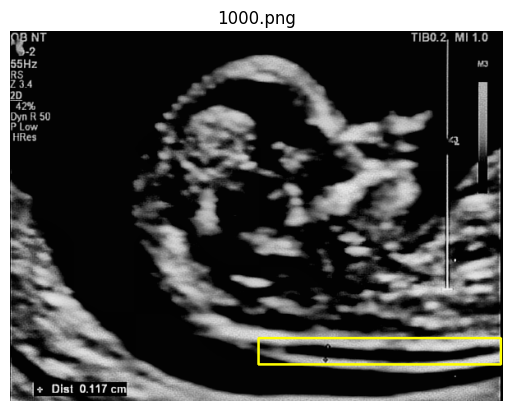

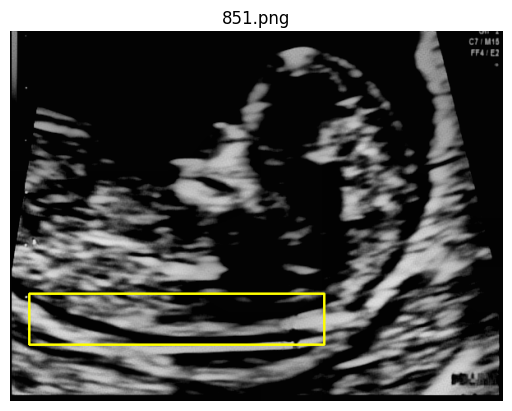

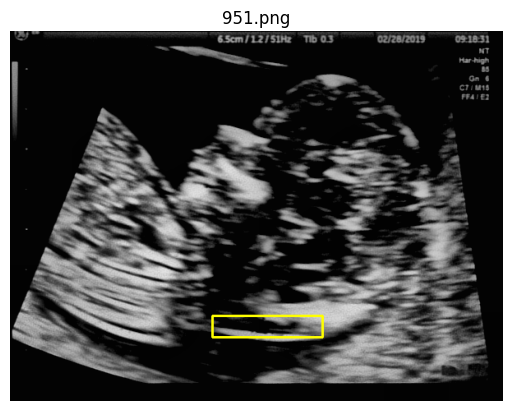

In [4]:
# Gather the images paths
dataset_path = 'dataset/Set2-Training&Validation Sets ANN Scoring system'
dataset_standard_path = os.path.join(dataset_path, 'Standard')
dataset_non_standard_path = os.path.join(dataset_path, 'Non-Standard')

valid_ids = df_nt['fname'].unique()
resize_dim = (600, 450)
images = []
image_ids = []
bounding_boxes = []

for i, fname in enumerate(os.listdir(dataset_standard_path)):
    if not fname.endswith('.png') or fname not in valid_ids:
        continue
    
    image_ids.append(fname)
    img_raw = cv2.imread(os.path.join(dataset_standard_path, fname), cv2.IMREAD_GRAYSCALE)

    # Resize image
    img = cv2.resize(img_raw, resize_dim)
    
    # Denoising

    img = lukinoising(img)

    # Equalize histogram to improve contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    
    # Convert to RGB for VGC16
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    images.append(img)
    
    # Get the bounding box coordinates
    h_min = df_nt[df_nt['fname'] == fname]['h_min'].values[0]
    h_max = df_nt[df_nt['fname'] == fname]['h_max'].values[0]
    w_min = df_nt[df_nt['fname'] == fname]['w_min'].values[0]
    w_max = df_nt[df_nt['fname'] == fname]['w_max'].values[0]
    
    # Resize the bounding box
    h_min = int(h_min * img.shape[0] / img_raw.shape[0])
    h_max = int(h_max * img.shape[0] / img_raw.shape[0])
    w_min = int(w_min * img.shape[1] / img_raw.shape[1])
    w_max = int(w_max * img.shape[1] / img_raw.shape[1])
    
    bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))
    
    # Draw the bounding box
    if not i%100:
        img_rect = cv2.rectangle(img.copy(), (w_min, h_min), (w_max, h_max), (255, 255, 0), 2)
       
        plt.imshow(img_rect, cmap='gray')
        plt.axis('off')
        plt.title(fname)
        plt.show()  

images = np.array(images)
bounding_boxes = np.array(bounding_boxes)

In [311]:
index = 73

img = images[index]
bb = bounding_boxes[index]

# bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))

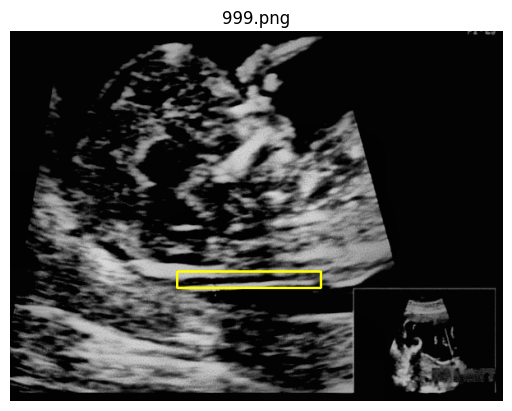

In [312]:
img_rect = cv2.rectangle(img.copy(), (bb[1], bb[0]), (bb[3], bb[2]), (255, 255, 0), 2)
       
plt.imshow(img_rect, cmap='gray')
plt.axis('off')
plt.title(fname)
plt.show()

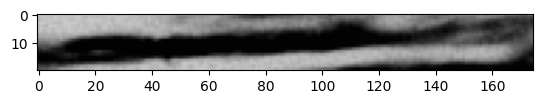

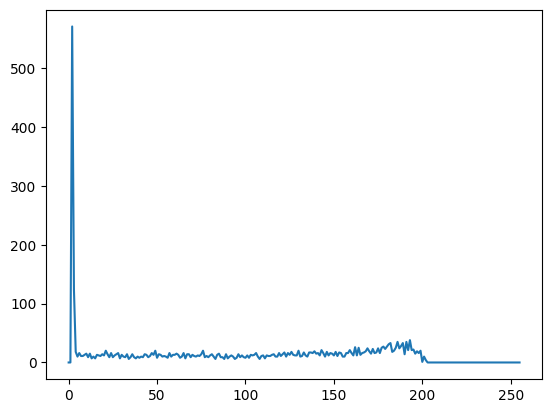

11.5


In [313]:
img_cut = img[bb[0]:bb[2], bb[1]:bb[3]]

plt.imshow(img_cut, cmap='gray')
plt.show()

histr = cv2.calcHist([img_cut],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

print(np.median(histr))

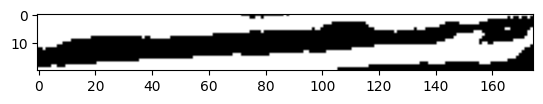

In [314]:
img_bin = img_cut.copy()

img_bin[img_bin < np.min(img_cut)+np.std(img_cut)] = 0
img_bin[img_bin >= np.min(img_cut)+np.std(img_cut)] = 255

plt.imshow(img_bin, cmap='gray')
plt.show()

(array([ 0,  0,  0, ..., 19, 19, 19]), array([ 72,  73,  74, ..., 172, 173, 174]))
10 89
(20, 175)


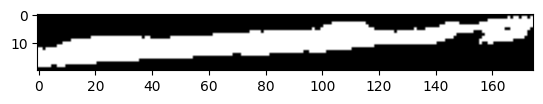

In [315]:
indexes = np.where(img_bin[:,:,0] == 0)

coor_i, coor_j = np.uint16(np.mean(indexes, axis=1))

print(indexes)
print(coor_i, coor_j)

seg = skimage.segmentation.flood(img_bin[:,:,0], (coor_i, coor_j), tolerance=0.1)

print(np.shape(seg))

plt.imshow(seg, cmap='gray')
plt.show()

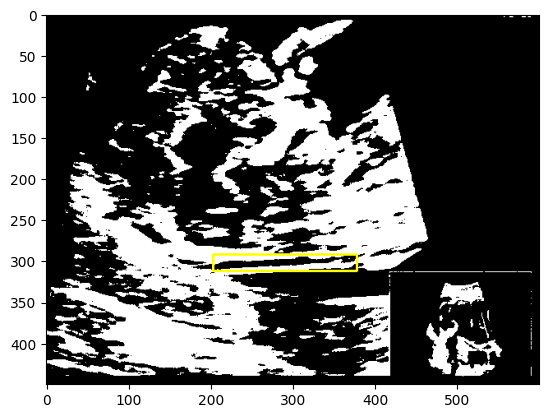

In [316]:
img_bin_comp = img.copy()

img_bin_comp[img_bin_comp < np.min(img_cut)+np.std(img_cut)] = 0
img_bin_comp[img_bin_comp >= np.min(img_cut)+np.std(img_cut)] = 255

img_rect_bin = cv2.rectangle(img_bin_comp.copy(), (bb[1], bb[0]), (bb[3], bb[2]), (255, 255, 0), 2)
       
plt.imshow(img_rect_bin, cmap='gray')
plt.show()

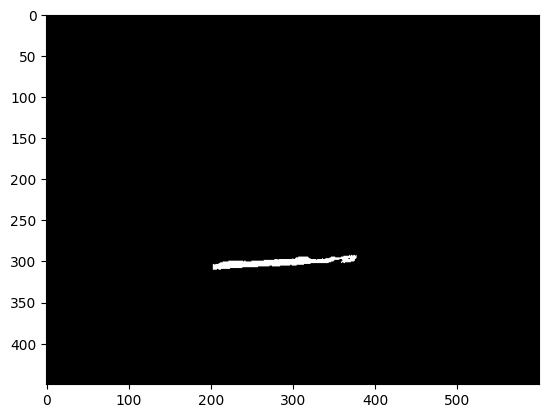

In [317]:
img_rect_bin_all = np.zeros(shape=(np.shape(img)[0],np.shape(img)[1]), dtype=np.uint8)

img_rect_bin_all[bb[0]:bb[2], bb[1]:bb[3]] = seg

plt.imshow(img_rect_bin_all, cmap='gray')
plt.show()

In [318]:
print(np.shape(img_rect_bin_all))
print(np.max(img_rect_bin_all))

(450, 600)
1


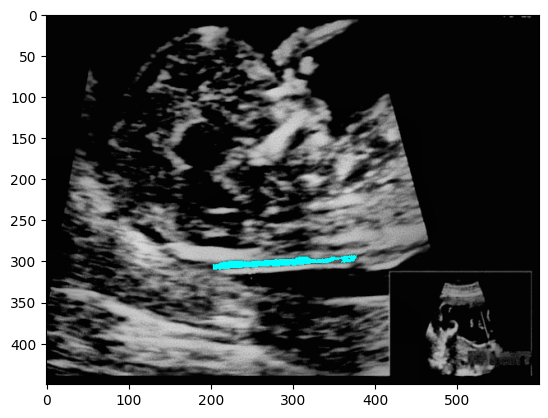

In [319]:
img_color = img.copy()

indexes2 = np.argwhere(img_rect_bin_all==1)

img_color[:,:,0][indexes2[:,0],indexes2[:,1]] = 0
img_color[:,:,1][indexes2[:,0],indexes2[:,1]] = 255
img_color[:,:,2][indexes2[:,0],indexes2[:,1]] = 255

plt.imshow(img_color)
plt.show()

In [320]:
def seg4me(img,bb):
    img_cut = img[bb[0]:bb[2], bb[1]:bb[3]]

    img_bin = img_cut.copy()

    img_bin[img_bin < np.min(img_cut)+np.std(img_cut)] = 0
    img_bin[img_bin >= np.min(img_cut)+np.std(img_cut)] = 255

    indexes = np.where(img_bin[:,:,0] == 0)

    coor_i, coor_j = np.uint16(np.mean(indexes, axis=1))

    seg = skimage.segmentation.flood(img_bin[:,:,0], (coor_i, coor_j), tolerance=0.1)

    img_rect_bin_all = np.zeros(shape=(np.shape(img)[0],np.shape(img)[1]), dtype=np.uint8)

    img_rect_bin_all[bb[0]:bb[2], bb[1]:bb[3]] = seg

    img_color = img.copy()

    indexes2 = np.argwhere(img_rect_bin_all==1)

    img_color[:,:,0][indexes2[:,0],indexes2[:,1]] = 0
    img_color[:,:,1][indexes2[:,0],indexes2[:,1]] = 255
    img_color[:,:,2][indexes2[:,0],indexes2[:,1]] = 255

    return img_color, img_rect_bin_all

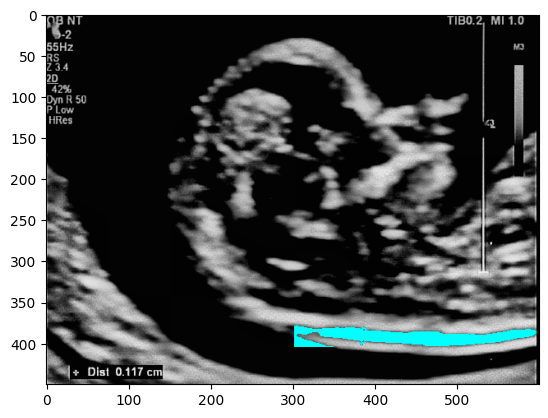

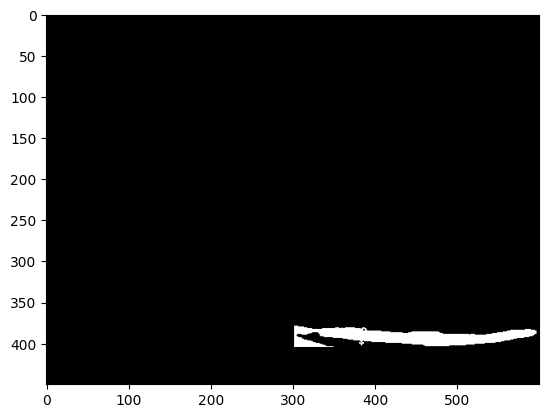

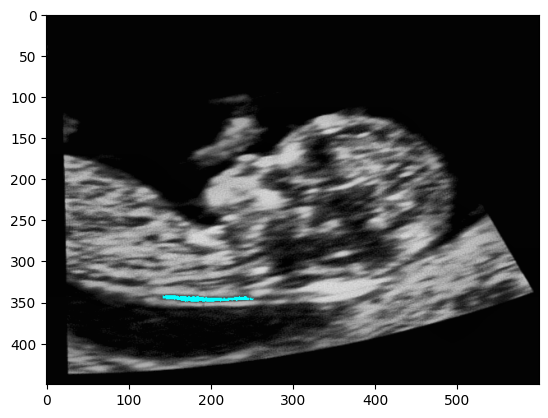

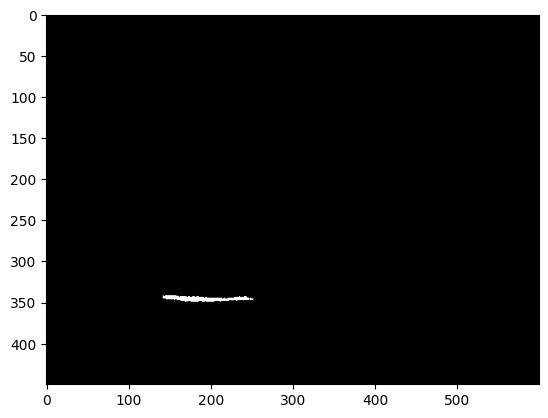

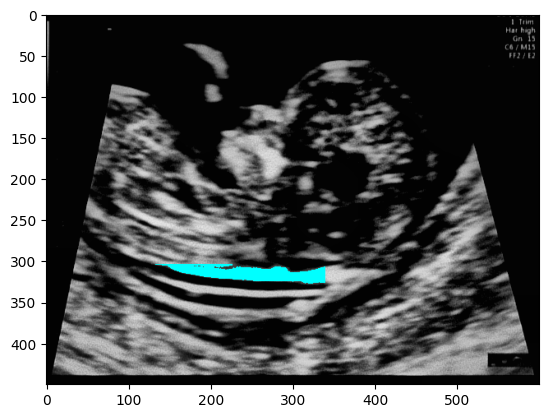

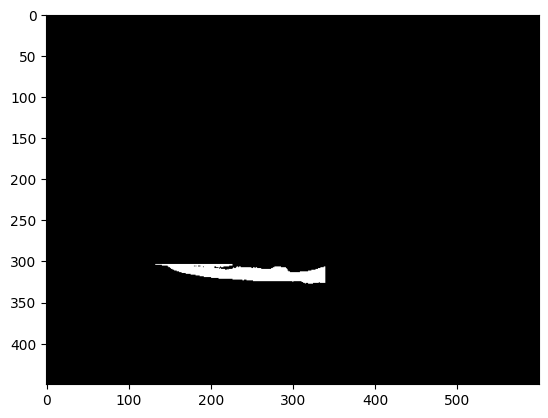

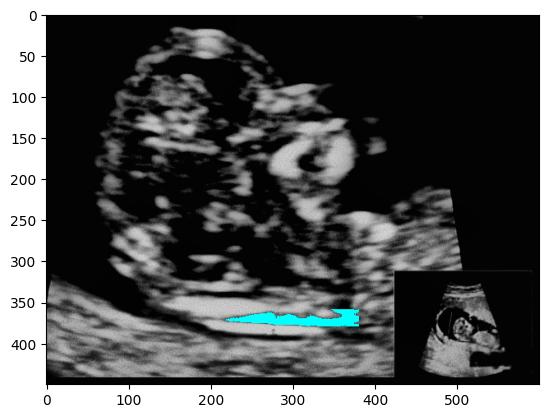

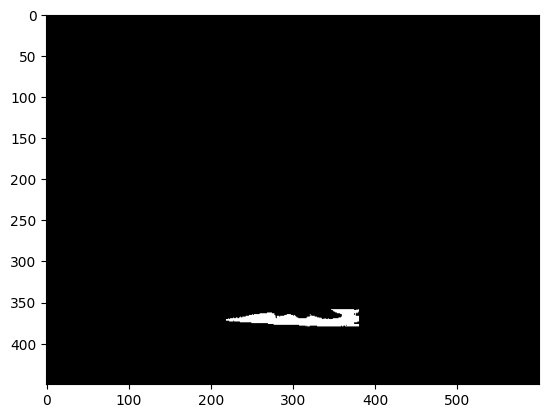

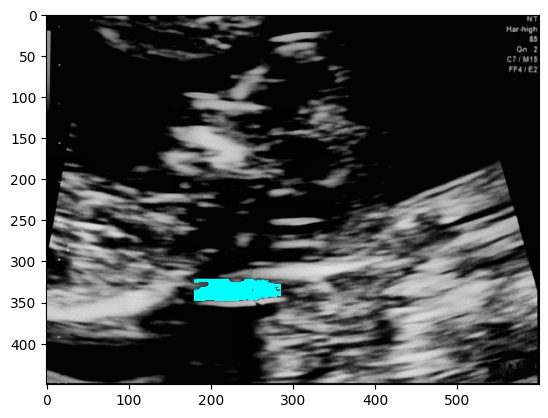

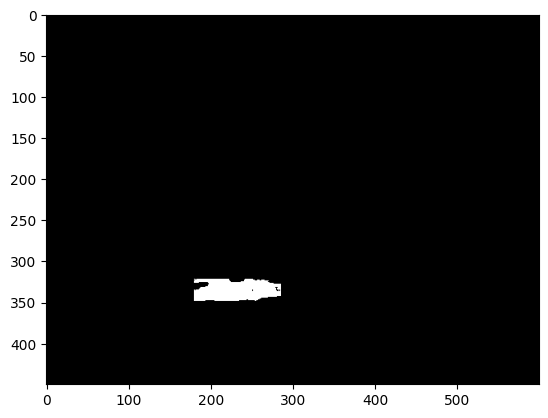

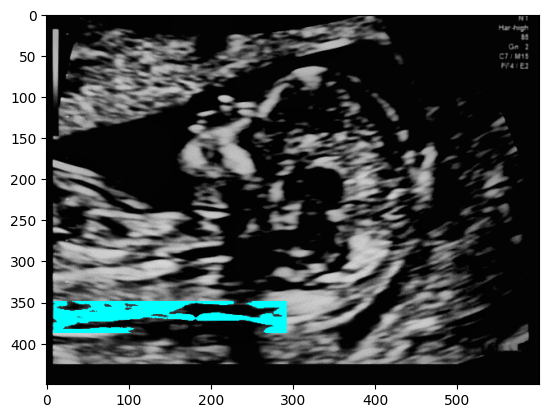

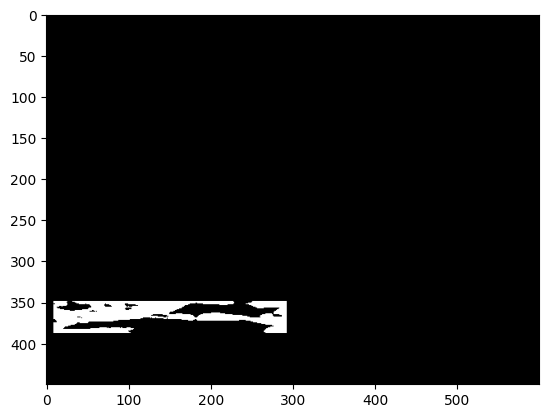

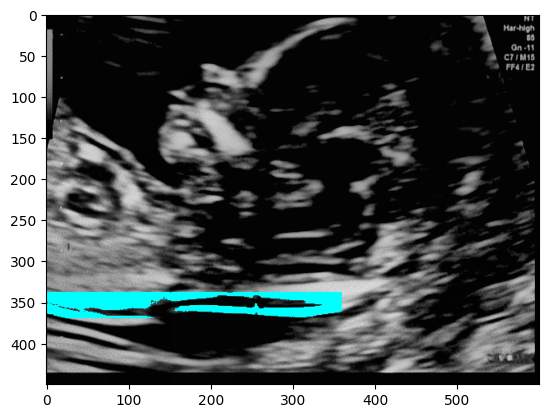

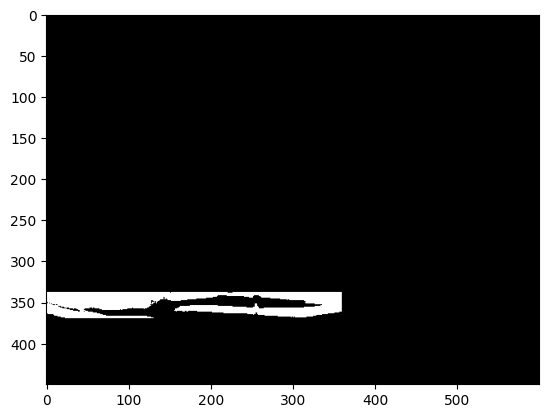

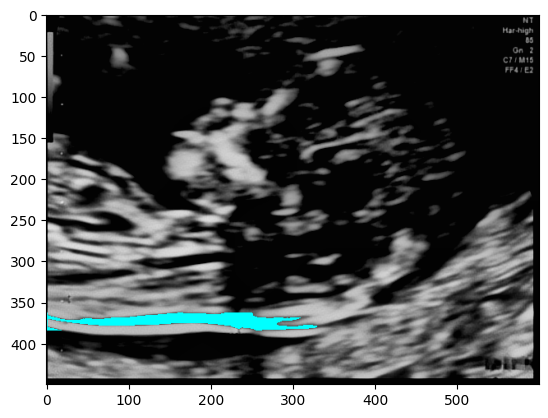

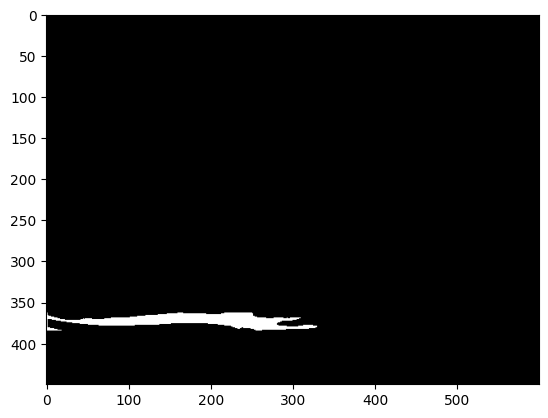

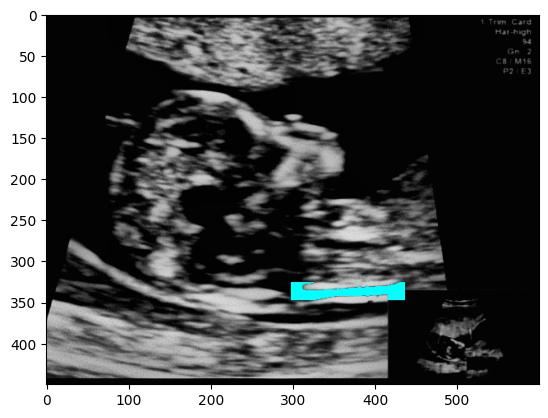

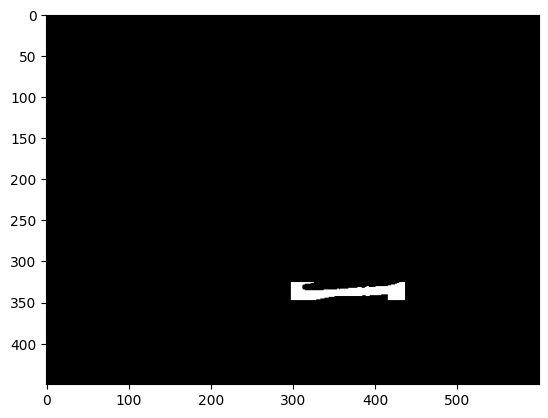

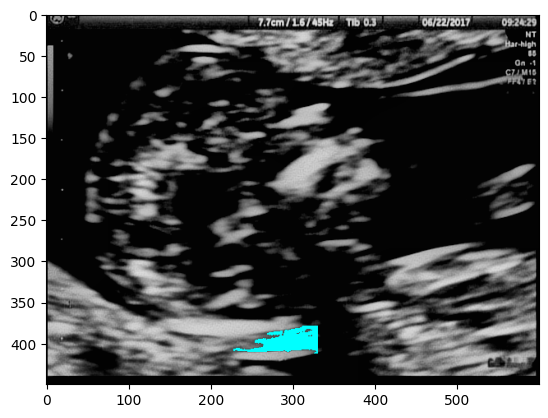

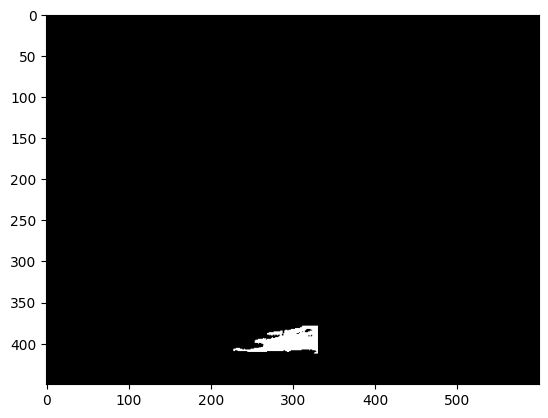

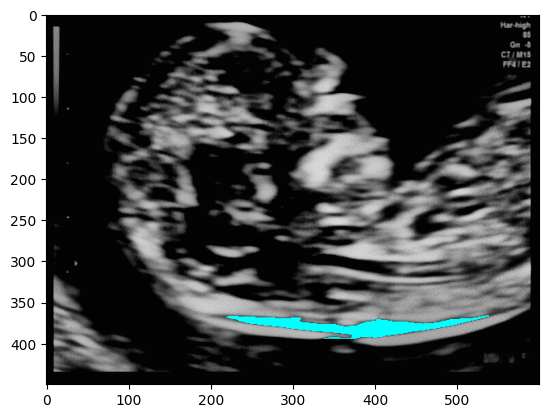

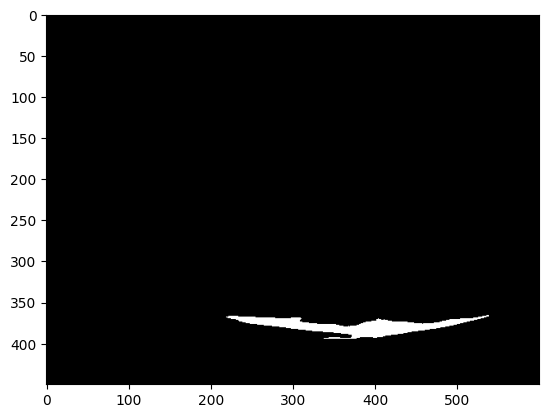

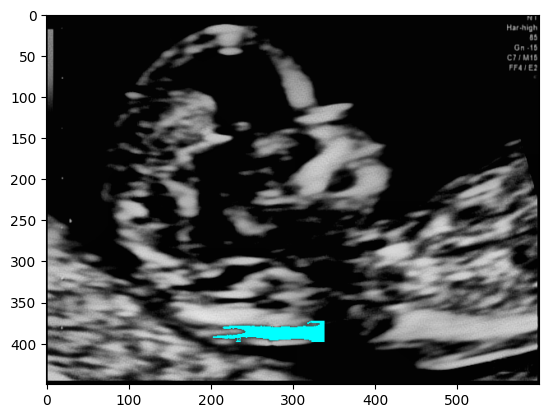

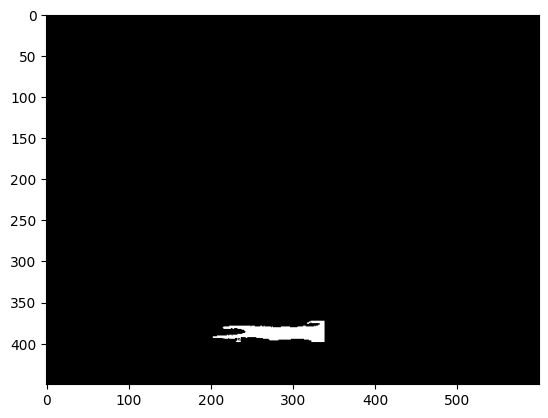

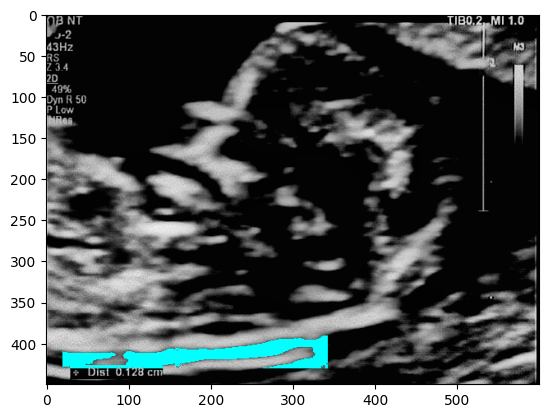

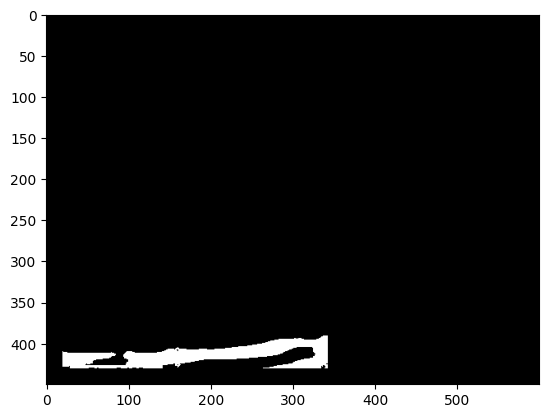

In [342]:
for i in range(0,len(images),20):

    img = images[i]
    bb = bounding_boxes[i]

    img_color, img_rect_bin_all = seg4me(img,bb)

    plt.imshow(img_color, cmap='gray')
    plt.show()

    plt.imshow(img_rect_bin_all, cmap='gray')
    plt.show()